In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# Visualization toolkit

In [2]:
def plot_solution(nodes, tour=None, cost=None, save_dir='results/tours'):
    fig = plt.figure(1)
    plt.clf()
    ax = fig.add_subplot(111)
    ax.scatter(nodes[:,0], nodes[:,1])
        
    if tour is None:
        plt.gca().set_aspect('equal', adjustable='box')
        return

    for a, b in zip(tour[:-1], tour[1:]):
        x = nodes[[a, b]].T[0]
        y = nodes[[a, b]].T[1]
        plt.plot(x, y, c='r', zorder=-1)

    ax.set_title(f'Tour length: {cost}')
    ax.set_aspect('equal')

    if save_dir is not None:
        plt.savefig(save_dir)

def plot_pheromone_trails(nodes, pheromones, save_dir='results/pheromones'):
    fig = plt.figure(2)
    plt.clf()
    ax = fig.add_subplot(111)
    ax.scatter(nodes[:,0], nodes[:,1])
    colors = plt.cm.jet(np.linspace(0, 1, 256))

    # normalizing pheromone matrix in the range [0, 255)
    if pheromones.min() == pheromones.max():
        pheromones_alpha = np.zeros(pheromones.shape)
    else:
        pheromones_alpha = (pheromones - pheromones.min()) / (pheromones.max() - pheromones.min())
    pheromones_color = (pheromones_alpha * 255).astype(int)
    
    for i in range(pheromones.shape[0]):
        for j in range(i+1, pheromones.shape[1]):
            x = nodes[[i, j]].T[0]
            y = nodes[[i, j]].T[1]
            edge_pheromone = pheromones_color[i,j]
            ax.plot(x, y, c=colors[edge_pheromone], alpha=pheromones_alpha[i, j])

    norm = mpl.colors.Normalize(vmin=0, vmax=1) 
    sm = plt.cm.ScalarMappable(cmap=plt.get_cmap('jet', 256), norm=norm) 
    sm.set_array([]) 

    plt.colorbar(sm, ax=ax, label="Pheromone intensity") 
    ax.set_title('Pheromone trails')
    ax.set_aspect('equal', adjustable='box')

    if save_dir is not None:
        plt.savefig(save_dir)

def plot_mean_cost(costs, save_dir=f'results/costs'):
    fig = plt.figure(3)
    plt.clf()
    ax = fig.add_subplot(111)
    ax.plot(costs)
    ax.set_title('Mean cost')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Cost')
    plt.grid()

    if save_dir is not None:
        plt.savefig(save_dir)
        

# Creating traveler salesman instance

In [3]:
class TSP:
    def __init__(self, cities):
        self.cities = cities
        self.cost_matrix = self._calculate_cost_matrix()

    @classmethod
    def from_instance(cls, cities):
        return cls(cities)
    
    @classmethod
    def random_instance(cls, n_cities):
        return cls(np.random.rand(n_cities, 2))
    
    def _calculate_cost_matrix(self):
       # calculate the cost matrix with the distances between cities i and j
       z = np.array([[complex(*c) for c in self.cities]])
       return abs(z.T - z) + 1e-8

    def get_cost(self, tours):
        """
        Compute the total cost of a batch of solutions

        Parameters
        ----------
        tours : np.array
            An array of shape (n_tours, n_cities) containing a set of tours.
            A tour is a list of cities visited by the agent.
        """
        tour_costs = np.zeros(tours.shape[0])
        for n in range(tours.shape[-1] - 1): # iterating on each edge walked bythe ants on their tour (except the last one)
            tour_costs += self.cost_matrix[tours[:, n], tours[:, n + 1]]
        
        return tour_costs
        
        

In [4]:
class AntSystemSolver:
    def __init__(
        self, 
        tsp_instance: TSP, 
        alpha=0.9, # pheromone decay
        beta=1.5, # importance of the pheromone over the quality of the edge
        ):
        self.instance = tsp_instance
        self.distance_matrix = tsp_instance.cost_matrix
        self.n_cities = tsp_instance.cities.shape[0]
        self.n_ants = self.n_cities
        
        self.pheromones = np.ones((self.n_cities, self.n_cities)) # initialize pheromone matrix

        self.alpha = alpha 
        self.beta = beta 

    def _transition_probability(self, current_city, visited_cities):
        """
        calculate the matrix of transition probability from city i to city j
        """
        mask = ~np.isin(np.arange(self.n_cities), visited_cities)
        
        weights = np.zeros(self.n_cities)
        weights[mask] = self.pheromones[current_city, mask] / (self.distance_matrix[current_city, mask] ** self.beta)

        # normalizing the weights to get the probabilities
        probs = weights/np.sum(weights, axis=-1, keepdims=True) 

        return probs
    
    def sample(
        self,
        n_tours=None,
        strategy='stochastic'
        ):
        if n_tours is None:
            n_tours = self.n_ants
    
        # get a tour for each ant
        tours = []
        for ant in range(n_tours):
            probs = self._transition_probability(ant, visited_cities=[ant]) # ant i starts at city i
            
            if strategy == 'stochastic':
                tour = np.concatenate(([ant], np.random.choice(np.arange(self.n_cities), 
                                                                replace=False, size=self.n_cities-1, p=probs)))
            elif strategy == 'greedy':
                tour = np.concatenate(([ant], np.argsort(np.non_zero(probs))))

            tours.append(tour)

        return np.array(tours)
    
    def update_pheromon(self, tours):
        tour_lengths = self.instance.get_cost(tours)

        """
        The for loop below calculates the delta_phero matrix for each of the k ants with the best tours.
        The delta_phero matrix has 1/tour_length[ant] in the position (i, j) if the ant visited the city j after the city i
        and 0 otherwise.
        """
        delta_pheros = np.zeros((self.n_ants, self.n_cities, self.n_cities))
        for ant in range(self.n_ants):
            tour = tours[ant]
            tour = np.concatenate((tour, [tour[0]])) # the ant returns to the starting city
            edges = np.array([[city, next_city] for city, next_city in zip(tour[:-1], tour[1:])])

            # the i-th element of the array below is the city visited after city i
            next_cities = edges[edges[:, 0].argsort()][:, 1]
            
            # scattering ones in the positions that correspond to edges walked by the ant
            values = np.ones(delta_pheros.shape[1])
            values[np.where(next_cities == tour[0])[0]] = 0 # discarding the edge which closes the loop
            np.put_along_axis(delta_pheros[ant], np.expand_dims(next_cities, 1), np.expand_dims(values, 1), axis=-1)
            delta_pheros[ant] = (delta_pheros[ant] + delta_pheros[ant].T) / tour_lengths[ant] # making the matrix symmetric and normalizing by the tour length

        # applying the pheromone update rule 
        self.pheromones = (1 - self.alpha) * self.pheromones + np.sum(delta_pheros, axis=0)
        

In [ ]:
class AntColonySystemSolver:
    def __init__(
        self, 
        tsp_instance: TSP, 
        initialization='random', # initialization strategy for the pheromone matrix
        n_ants=10, # number of ants
        alpha=0.9, # pheromone decay in global update
        rho=0.1, # pheromone decay in local update
        beta=1.5, # importance of the pheromone over the quality of the edge
        q0=0.9, # probability of choosing the greedy strategy
        ):
        self.instance = tsp_instance
        self.distance_matrix = tsp_instance.cost_matrix
        self.n_cities = tsp_instance.cities.shape[0]
        self.n_ants = n_ants
        
        self.pheromones = np.ones((self.n_cities, self.n_cities)) # initialize pheromone matrix

        self.alpha = alpha 
        self.beta = beta 

    def _transition_probability(self, current_city, visited_cities):
        """
        calculate the matrix of transition probability from city i to city j
        """
        mask = ~np.isin(np.arange(self.n_cities), visited_cities)
        
        weights = np.zeros(self.n_cities)
        weights[mask] = self.pheromones[current_city, mask] / (self.distance_matrix[current_city, mask] ** self.beta)

        # normalizing the weights to get the probabilities
        probs = weights/np.sum(weights, axis=-1, keepdims=True) 

        return probs
    
    def sample(
        self,
        n_tours=None,
        strategy='stochastic'
        ):
        if n_tours is None:
            n_tours = self.n_ants
    
        # get a tour for each ant
        tours = []
        for ant in range(n_tours):
            probs = self._transition_probability(ant, visited_cities=[ant]) # ant i starts at city i
            
            if strategy == 'stochastic':
                tour = np.concatenate(([ant], np.random.choice(np.arange(self.n_cities), 
                                                                replace=False, size=self.n_cities-1, p=probs)))
            elif strategy == 'greedy':
                tour = np.concatenate(([ant], np.argsort(np.non_zero(probs))))

            tours.append(tour)

        return np.array(tours)
    
    def update_pheromon(self, tours):
        tour_lengths = self.instance.get_cost(tours)

        """
        The for loop below calculates the delta_phero matrix for each of the k ants with the best tours.
        The delta_phero matrix has 1/tour_length[ant] in the position (i, j) if the ant visited the city j after the city i
        and 0 otherwise.
        """
        delta_pheros = np.zeros((self.n_ants, self.n_cities, self.n_cities))
        for ant in range(self.n_ants):
            tour = tours[ant]
            tour = np.concatenate((tour, [tour[0]])) # the ant returns to the starting city
            edges = np.array([[city, next_city] for city, next_city in zip(tour[:-1], tour[1:])])

            # the i-th element of the array below is the city visited after city i
            next_cities = edges[edges[:, 0].argsort()][:, 1]
            
            # scattering ones in the positions that correspond to edges walked by the ant
            values = np.ones(delta_pheros.shape[1])
            values[np.where(next_cities == tour[0])[0]] = 0 # discarding the edge which closes the loop
            np.put_along_axis(delta_pheros[ant], np.expand_dims(next_cities, 1), np.expand_dims(values, 1), axis=-1)
            delta_pheros[ant] = (delta_pheros[ant] + delta_pheros[ant].T) / tour_lengths[ant] # making the matrix symmetric and normalizing by the tour length

        # applying the pheromone update rule 
        self.pheromones = (1 - self.alpha) * self.pheromones + np.sum(delta_pheros, axis=0)
        

In [5]:
NUM_IT = 100

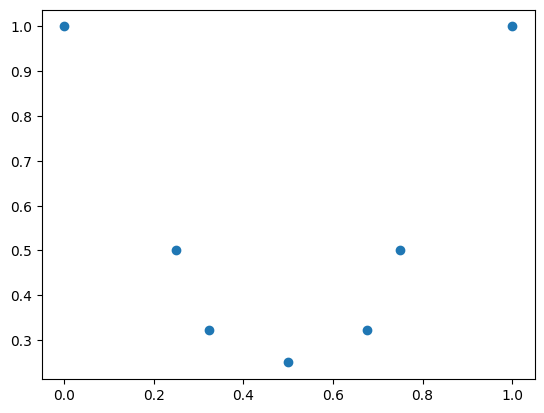

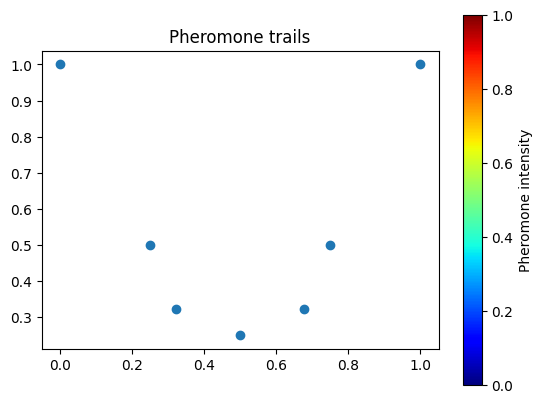

In [8]:
# debugging

# square
# cities = np.array([[2, 1], [2, 2], [1, 1], [1, 2]])
# tsp = TSP.from_instance(cities)

# circle
cities = np.array([[0, 1], [0.25, 0.5], [0.3232, 0.3232], [0.5, 0.25], [0.6768, 0.3232], [0.75, 0.5], [1, 1]])
tsp = TSP.from_instance(cities)

# random
# tsp = TSP.random_instance(7)

solver = AntSystemSolver(tsp)

plot_solution(tsp.cities, save_dir=None)
plot_pheromone_trails(tsp.cities, solver.pheromones, save_dir=None)

Iteration 0: avg cost: 3.3650746451457585, min cost: 3.2064715696364914
--> Best tour so far: [4 5 2 3 6 1 0], cost: 3.2064715696364914, it: 0,
Iteration 1: avg cost: 3.466156742165566, min cost: 2.75724932249777
--> Best tour so far: [4 3 5 2 1 0 6], cost: 2.75724932249777, it: 1,
Iteration 2: avg cost: 3.260098798622399, min cost: 2.7665527569490735
Iteration 3: avg cost: 3.3637428175922004, min cost: 3.0020721587924526
Iteration 4: avg cost: 3.353372179774477, min cost: 2.9482433147090195
Iteration 5: avg cost: 3.3494996253860108, min cost: 2.9466779124598315
Iteration 6: avg cost: 3.413863858376188, min cost: 2.99160760531418
Iteration 7: avg cost: 3.239749595498618, min cost: 2.919494991478062
Iteration 8: avg cost: 3.1887078575822736, min cost: 2.6488791070076374
--> Best tour so far: [3 1 2 4 5 6 0], cost: 2.6488791070076374, it: 8,
Iteration 9: avg cost: 3.2527783646230253, min cost: 2.7557305296553083
Iteration 10: avg cost: 3.2962026526149124, min cost: 2.94824331470902
Itera

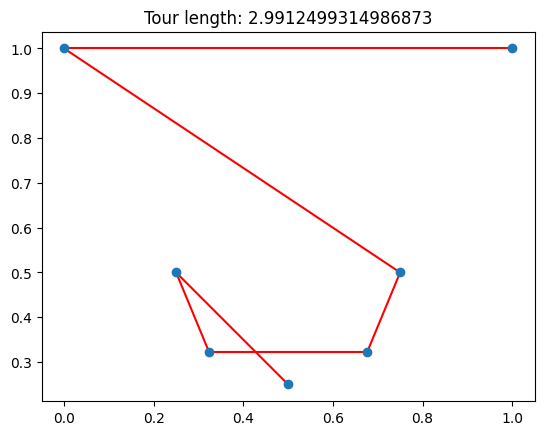

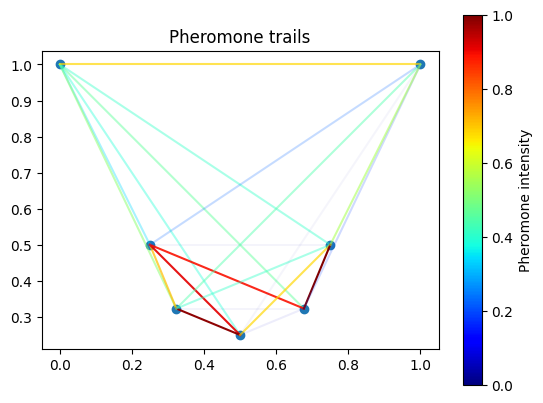

In [9]:
least_cost = np.inf
avg_costs = []
for it in range(NUM_IT):
    # sampling solutions
    tours = solver.sample()

    # comparing the cost of the tours with the best tour found so far
    costs = tsp.get_cost(tours)
    best_tour = tours[np.argmin(costs)]
    avg_cost = np.mean(costs)
    avg_costs.append(avg_cost)
    print(f'Iteration {it}: avg cost: {avg_cost}, min cost: {np.min(costs)}')
    if costs.min() < least_cost:
        least_cost = costs.min()
        print(f'--> Best tour so far: {best_tour}, cost: {least_cost}, it: {it},')
        # plt.show()
        # plt.close()

    # plotting
    plot_solution(tsp.cities, best_tour, np.min(costs), save_dir=f'results/tours/tour_{it}')
    plot_pheromone_trails(tsp.cities, solver.pheromones, save_dir=f'results/pheromones/trails_{it}')
    
    # updating the pheromone matrix
    solver.update_pheromon(tours)

plot_mean_cost(avg_costs, save_dir=f'results/costs/costs_{it}')
plt.close()